In [1]:
#pip install ipyleaflet

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime as dt

from ipyleaflet import Map, basemaps, Marker, AntPath, WidgetControl, Popup, basemap_to_tiles
from ipywidgets import IntSlider, jslink, HTML

from math import radians, sin, cos, asin, sqrt

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

=======================================================================================================================

### Функции для визуализации треков

In [3]:
def track(tracker_code):
    fig, ax = plt.subplots(1, 1, figsize = (20, 15))
    
    ax.plot(df[df.tracker_code == tracker_code]['longitude'], 
            df[df.tracker_code == tracker_code]['latitude'])
    
    ax.set_title(f'tracker_code = {tracker_code}', fontsize = 20)
    ax.set_xlabel('Долгота', fontsize = 20)
    ax.set_ylabel('Широта', fontsize = 20)
    ax.grid()

In [4]:
def track_on_map(tracker_code):
    coordinates = list(zip(df[df.tracker_code == tracker_code]['latitude'], 
                           df[df.tracker_code == tracker_code]['longitude']))
    
    locations = []
    
    for i in coordinates:
        locations.append(list(i))
        
    m = Map(center=coordinates[0],
            basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik),
            zoom=4)
        
    marathon_path = AntPath(
        locations=locations,
        dash_array=[1, 10],
        delay=1000,
        color='#9500ff',
        pulse_color='#9500ff')
        
    m.add_layer(marathon_path)                                    
        
    zoom_slider = IntSlider(description='Масштаб:', min=1, max=20, value=12)
    jslink((zoom_slider, 'value'), (m, 'zoom'))
    widget_control1 = WidgetControl(widget=zoom_slider, position='topright')
    m.add_control(widget_control1)
        
    return m

### Функция для расчёта расстояния между двумя точками

In [5]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2) ** 2
    c = 2 * asin(sqrt(a))
    earth_radius = 6371 
    return c * earth_radius

### Функции для поиска выбросов

In [6]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]

In [7]:
def outliers_z_score(ys, threshold=3):
    mean_y = np.mean(ys)
    std_y = np.std(ys)
    z_scores = [(y - mean_y) / std_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)[0]

=======================================================================================================================

In [8]:
data = pd.read_csv('point_202310101547.csv', sep = ';')

In [9]:
df = data.copy()
display(df)
df.info()

,tracker_code,navigation_time,received_time,latitude,longitude,altitude,nsat,course,speed,pdop,geom
0,1861179465,2023-05-11 00:00:16.000,2023-05-10 23:46:01.454,61.050015,76.130463,0.0,3.0,14,2,0.0,POINT (76.13046333103685 61.050014987366744)
1,1861179465,2023-05-11 00:02:30.000,2023-05-10 23:48:07.809,61.044565,76.127673,0.0,5.0,356,4,0.0,POINT (76.12767333074652 61.044564990104305)
2,1861179465,2023-05-11 00:02:24.000,2023-05-10 23:48:07.688,61.044437,76.127673,0.0,5.0,22,4,0.0,POINT (76.12767333074652 61.04443666316672)
3,1861179465,2023-05-11 00:01:52.000,2023-05-10 23:47:57.702,61.044362,76.127567,0.0,5.0,8,2,0.0,POINT (76.12756662911912 61.04436166608808)
4,1861179465,2023-05-11 00:02:12.000,2023-05-10 23:47:57.584,61.044265,76.127608,0.0,5.0,8,6,0.0,POINT (76.12760832908741 61.04426498083497)
...,...,...,...,...,...,...,...,...,...,...,...
57321004,382758,2023-05-11 21:19:33.000,2023-05-12 09:34:26.941,61.266212,75.195137,29.0,12.0,0,0,1.0,POINT (75.19513748474306 61.26621165807969)
57321005,382758,2023-05-11 21:19:23.000,2023-05-12 09:34:26.941,61.266213,75.195139,29.0,12.0,0,0,1.0,POINT (75.19513916112369 61.26621331350557)
57321006,382758,2023-05-11 21:19:12.000,2023-05-12 09:34:26.941,61.266215,75.195137,29.0,12.0,0,0,1.0,POINT (75.19513748474306 61.2662149898862)
57321007,382758,2023-05-11 21:19:02.000,2023-05-12 09:34:26.941,61.266216,75.195137,29.0,12.0,0,0,1.0,POINT (75.19513664655274 61.26621582807652)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57321009 entries, 0 to 57321008
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   tracker_code     int64  
 1   navigation_time  object 
 2   received_time    object 
 3   latitude         float64
 4   longitude        float64
 5   altitude         float64
 6   nsat             float64
 7   course           int64  
 8   speed            int64  
 9   pdop             float64
 10  geom             object 
dtypes: float64(5), int64(3), object(3)
memory usage: 4.7+ GB


In [10]:
df.columns

Index(['tracker_code', 'navigation_time', 'received_time', 'latitude',
       'longitude', 'altitude', 'nsat', 'course', 'speed', 'pdop', 'geom'],
      dtype='object')

In [11]:
df.isna().sum()

tracker_code              0
navigation_time           0
received_time             0
latitude                  0
longitude                 0
altitude            3594814
nsat                5026348
course                    0
speed                     0
pdop               21517226
geom                      0
dtype: int64

# Сортировка датасета по времени (navigation_time)

In [12]:
df['navigation_time'] = pd.to_datetime(df['navigation_time'])
df = df.sort_values(by = 'navigation_time')
df.reset_index(drop = True, inplace = True)
df.head()

,tracker_code,navigation_time,received_time,latitude,longitude,altitude,nsat,course,speed,pdop,geom
0,236016544,2023-05-11,2023-05-11 00:00:12.302,65.945359,78.159539,8.0,15.0,0,0,NaN,POINT (78.159538567569 65.94535879230718)
1,651752,2023-05-11,2023-05-11 01:49:54.732,70.342662,68.851393,34.0,20.0,8,0,NaN,POINT (68.85139297434394 70.34266198061934)
2,6251723,2023-05-11,2023-05-11 00:01:02.046,61.019924,76.778961,63.0,12.0,0,0,NaN,POINT (76.77896116319553 61.01992414356673)
3,2407667,2023-05-11,2023-05-11 00:00:43.420,0.000000,0.000000,0.0,0.0,0,0,0.0,POINT (0 0)
4,2032407,2023-05-11,2023-05-11 00:02:08.300,64.446120,76.437412,-16384.0,15.0,0,5,1.0,POINT (76.43741164273523 64.4461199791278)


# Очистка данных

Отфильтруем датасет по минимальной и максимальной скорости машин так, чтобы она не была равна 0 и не превышала 170 км/ч.

In [13]:
df.drop(df[(df['speed'] == 0) | (df['speed'] > 170)].index, inplace = True)
df.reset_index(drop = True, inplace = True)

## Округление координат

In [14]:
# Округляем координаты до 3-го знака после запятой.

#df['latitude'] = df['latitude'].apply(lambda x: round(x, 3))
#df['longitude'] = df['longitude'].apply(lambda x: round(x, 3))
#df.head()

## Поиск дублирующихся записей

In [15]:
df['geom'].value_counts()

geom
POINT (76.5428683060554 60.9416133214118)       4928
POINT (0 0)                                     4648
POINT (111.80046499515895 60.25966666644897)    3647
POINT (76.69303127487494 63.47563934127699)     3204
POINT (76.56407988550237 66.06843658398567)     2513
                                                ... 
POINT (67.09594831967166 63.47965249174266)        1
POINT (73.73196996136848 61.41879915525643)        1
POINT (54.03418913344717 52.93004582704279)        1
POINT (80.82510099765497 63.43915297962705)        1
POINT (68.99523083330021 60.98812915407776)        1
Name: count, Length: 31680231, dtype: int64

In [16]:
df[df.geom == 'POINT (0 0)'].head()

,tracker_code,navigation_time,received_time,latitude,longitude,altitude,nsat,course,speed,pdop,geom
8327,2408023,2023-05-11 00:00:48,2023-05-11 00:02:07.151,0.0,0.0,48.0,14.0,163,24,1.0,POINT (0 0)
9007,2140694,2023-05-11 00:00:52,2023-05-11 00:04:21.458,0.0,0.0,-16384.0,15.0,293,1,1.0,POINT (0 0)
16263,2060364405,2023-05-11 00:01:34,2023-05-11 00:52:13.765,0.0,0.0,70.0,12.0,309,95,1.0,POINT (0 0)
35824,2060364405,2023-05-11 00:03:27,2023-05-11 00:52:13.869,0.0,0.0,71.0,12.0,266,87,1.0,POINT (0 0)
51775,2060364405,2023-05-11 00:05:00,2023-05-11 00:52:13.975,0.0,0.0,79.0,12.0,258,93,1.0,POINT (0 0)


Значения столбца **geom** равные 'POINT (0 0)' не позволяют определить местоположение машины, поэтому соответствующие им строки следует удалить.

In [17]:
df.drop(df[df['geom'] == 'POINT (0 0)'].index, axis = 0, inplace = True)
df.reset_index(drop = True, inplace = True)

In [18]:
# Осуществляем поиск дубликатов по сочетанию столбцов tracker_code, latitude и longitude

df[['tracker_code', 'latitude', 'longitude']].value_counts()

tracker_code  latitude   longitude 
361432        60.941613  76.542868     4928
472158        60.259667  111.800465    3647
153104209     63.475639  76.693031     3204
83888885      66.068437  76.564080     2513
472172        61.083878  72.537522     1731
                                       ... 
2026167       61.194129  74.486613        1
              61.194094  74.486504        1
              61.194050  74.486451        1
              61.194015  74.486363        1
4294967295    57.131278  65.561290        1
Name: count, Length: 32263271, dtype: int64

Визуализируем один из таких треков.

In [19]:
#track(tracker_code = 1400015434)

Посмотрим как трек выглядит на реальной карте.

In [20]:
#track_on_map(tracker_code = 1400015434)

Предположим, что дубликаты соответствуют моментам, когда машина была без движения. Удалим их.

In [21]:
df.drop_duplicates(subset = ['tracker_code', 'latitude', 'longitude'], inplace = True)

Снова визуализируем трек.

In [22]:
#track(tracker_code = 1400015434)

In [23]:
#track_on_map(tracker_code = 1400015434)

Визуально ничего не изменилось, значит потерь, искажающих анализ, не было. В результате данные были очищены от лишней информации и датасет был уменьшен. Проверим есть ли в датасете дублирующиеся записи без учёта столбца tracker_code.

In [24]:
# Осуществляем поиск дубликатов по сочетанию столбцов navigation_time, latitude, longitude, altitude и speed

df[['navigation_time', 'latitude', 'longitude', 'altitude', 'speed']].value_counts()

navigation_time      latitude   longitude  altitude  speed
2023-05-11 08:37:02  63.823100  76.791890  56.0      14       5
2023-05-11 10:51:04  63.783921  76.738925  53.0      14       5
2023-05-11 09:36:17  63.770691  76.749250  61.0      52       5
2023-05-11 15:34:50  63.813201  76.778331  64.0      42       5
2023-05-11 15:30:18  63.792840  76.746330  62.0      24       5
                                                             ..
2023-05-11 06:05:44  61.023362  76.326490  39.0      53       1
                     61.018734  76.779007  42.0      14       1
                     61.018392  76.814489  24.0      63       1
                     61.008347  72.321297  35.0      28       1
2023-05-11 23:59:59  70.555232  68.303349  1.0       32       1
Name: count, Length: 30659222, dtype: int64

In [25]:
# Осуществляем поиск дубликатов по сочетанию столбцов navigation_time, latitude и longitude

ser = df[['navigation_time', 'latitude', 'longitude']].value_counts()
ser

navigation_time      latitude   longitude
2023-05-11 18:00:16  63.816745  76.783200    5
2023-05-11 08:29:39  63.791755  76.744148    5
2023-05-11 05:23:06  63.710923  76.811688    5
2023-05-11 10:51:24  63.783653  76.738275    5
2023-05-11 08:34:16  63.814271  76.779793    5
                                            ..
2023-05-11 06:05:09  60.495621  77.263664    1
                     60.482463  72.342507    1
                     60.470085  72.700775    1
                     60.413855  74.946471    1
2023-05-11 23:59:59  70.555232  68.303349    1
Name: count, Length: 31849395, dtype: int64

In [26]:
ser[:20]

navigation_time      latitude   longitude
2023-05-11 18:00:16  63.816745  76.783200    5
2023-05-11 08:29:39  63.791755  76.744148    5
2023-05-11 05:23:06  63.710923  76.811688    5
2023-05-11 10:51:24  63.783653  76.738275    5
2023-05-11 08:34:16  63.814271  76.779793    5
2023-05-11 06:26:42  63.780468  76.747480    5
2023-05-11 05:19:52  63.729103  76.843241    5
2023-05-11 12:11:28  63.809298  76.772970    5
2023-05-11 04:53:09  63.783901  76.738728    5
2023-05-11 09:34:03  63.776193  76.713830    5
2023-05-11 12:23:15  63.783960  76.739981    5
2023-05-11 05:49:40  63.701996  76.781850    5
2023-05-11 08:21:51  63.797683  76.755741    5
2023-05-11 08:12:40  63.832458  76.800838    5
2023-05-11 15:32:19  63.799243  76.758766    5
2023-05-11 12:23:05  63.784053  76.740630    5
2023-05-11 08:23:13  63.792235  76.745065    5
2023-05-11 09:13:15  63.828113  76.798726    5
2023-05-11 09:18:34  63.809386  76.772868    5
2023-05-11 08:38:31  63.827815  76.798278    5
Name: count, dtype

Посмотрим tracker_code дублирующихся записей на первом примере.

In [27]:
ser.index[0]

(Timestamp('2023-05-11 18:00:16'), 63.81674499805475, 76.7831999754494)

In [28]:
ser_dup1 = df[(df['latitude'] == 63.7910199942512) & (df['longitude'] == 76.74276596790709)]['tracker_code']
list_dup1 = list(ser_dup1)
list_dup1.sort()
list_dup1

[102059784, 1012059784, 1022059784, 1032059784, 1042059784]

Визуализируем эти треки.

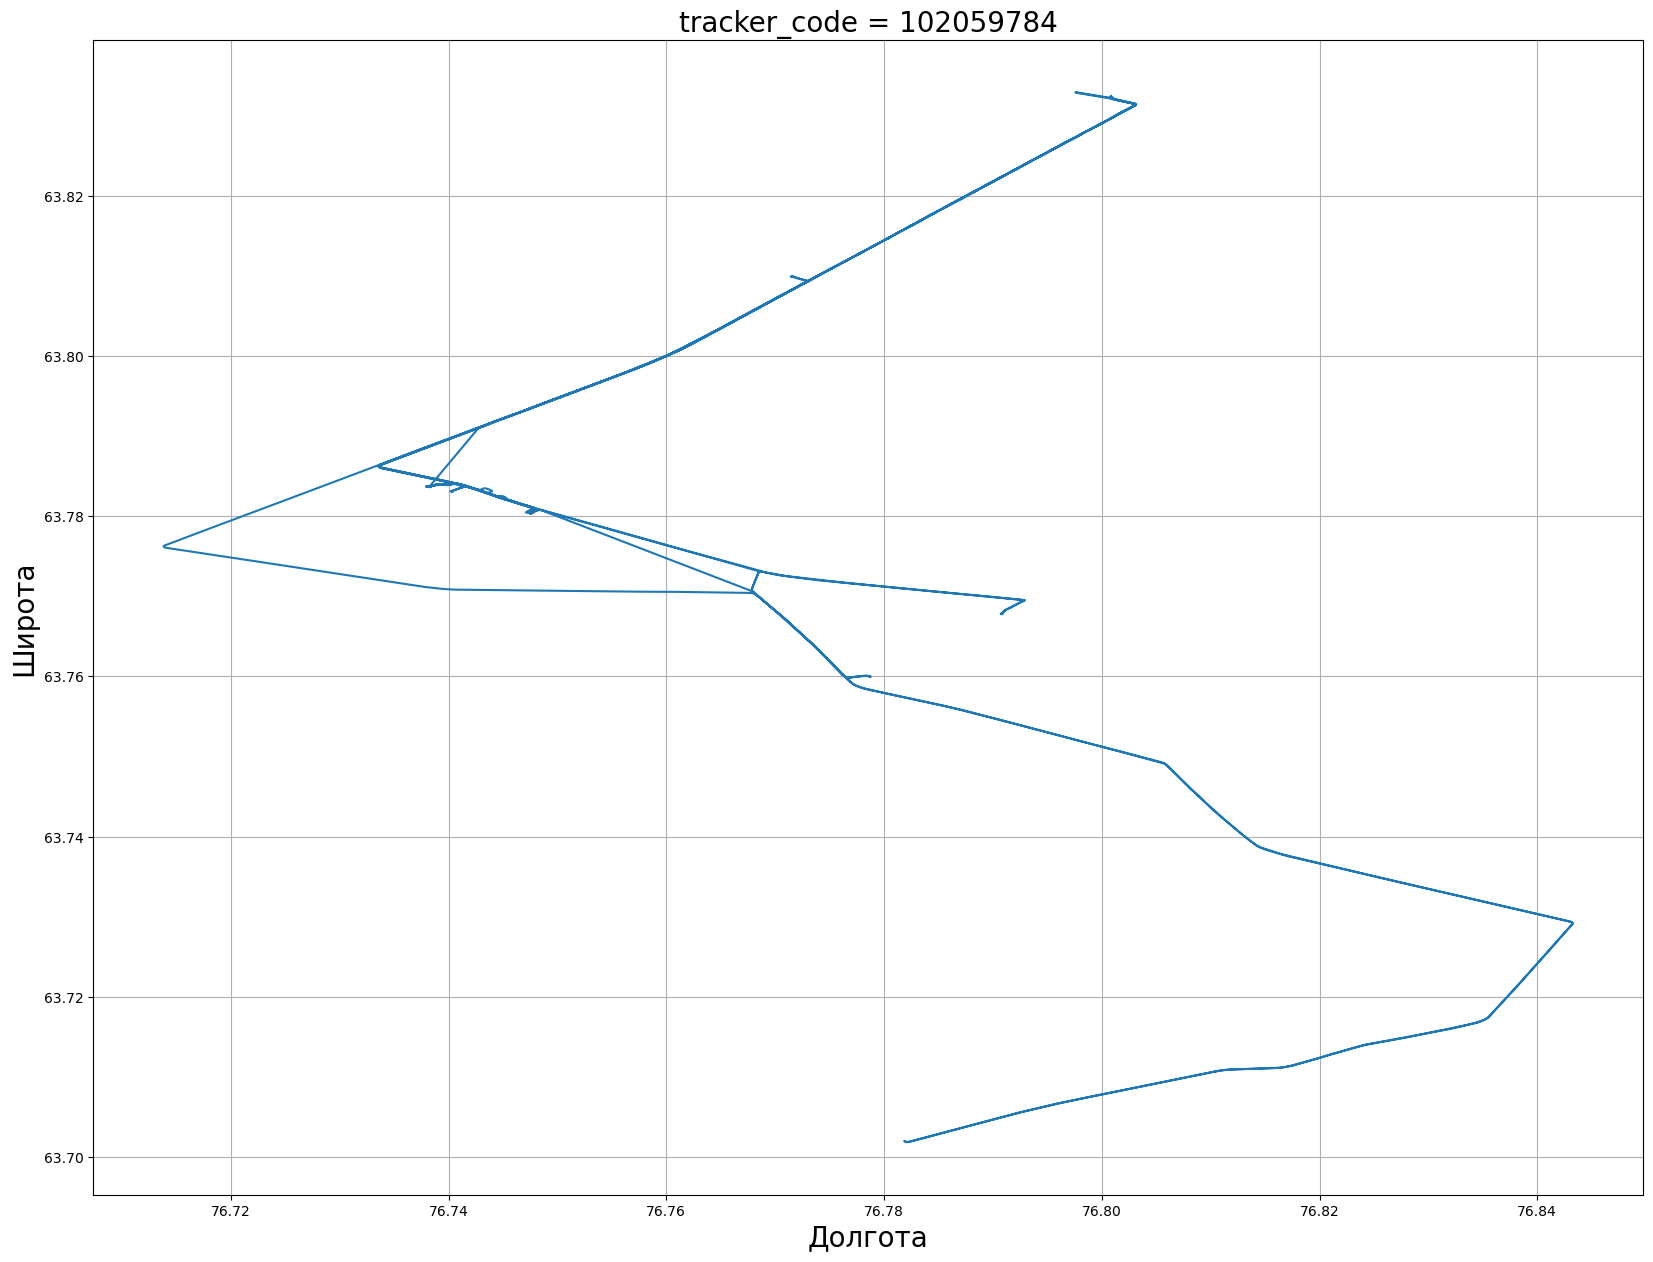

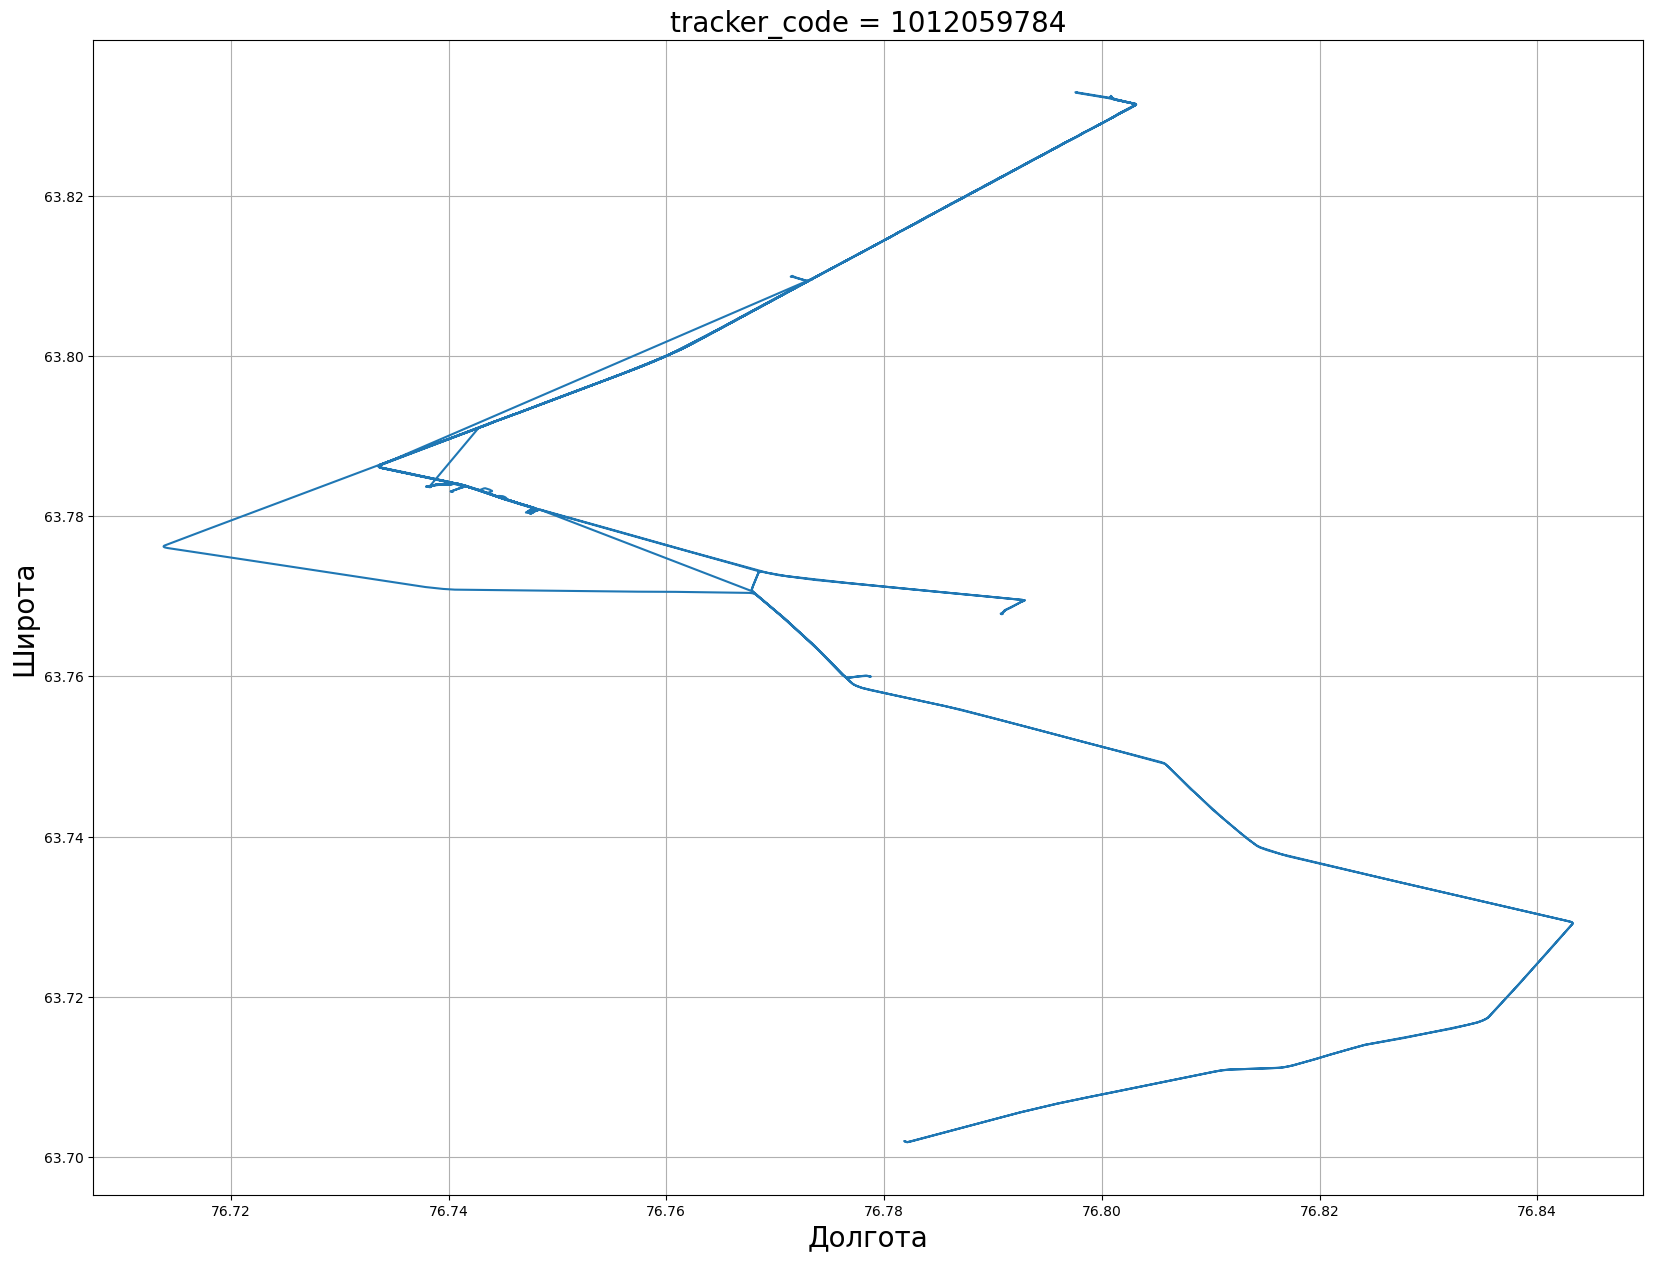

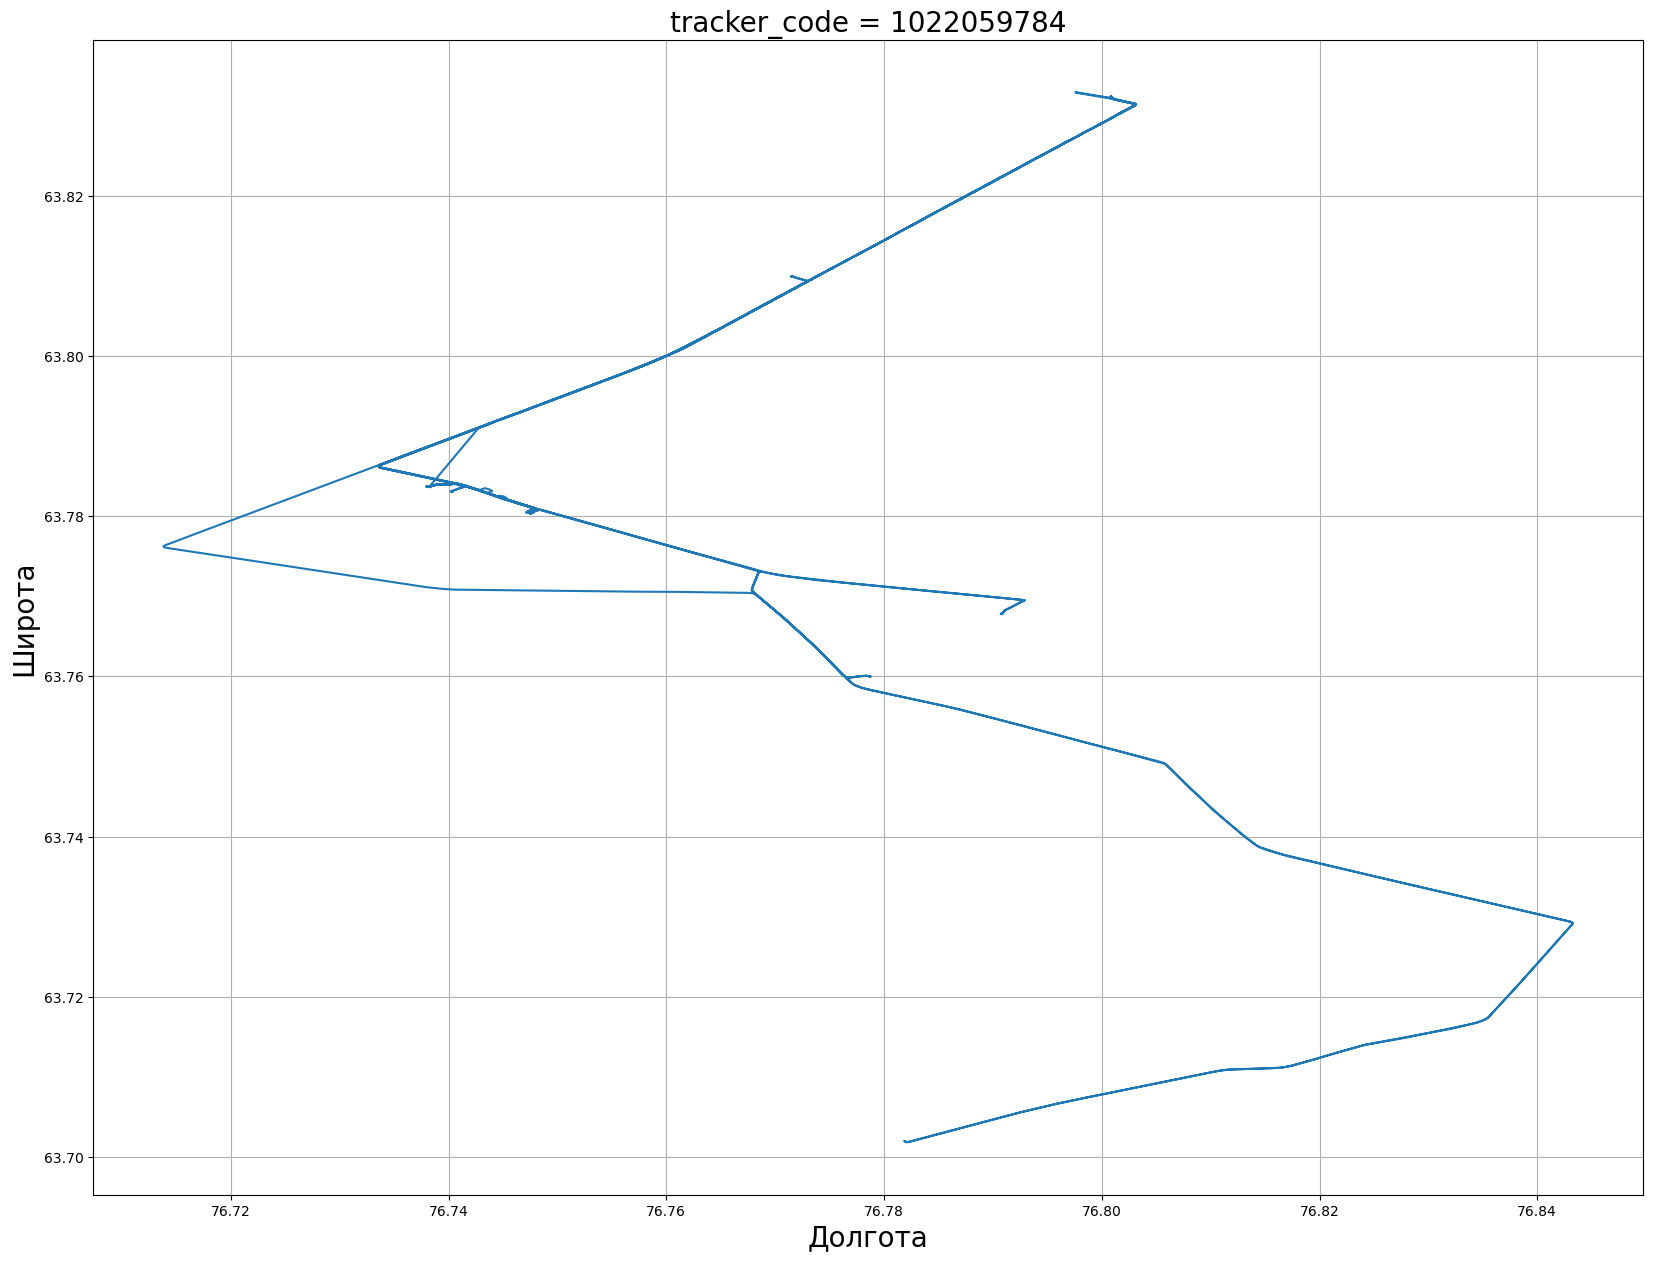

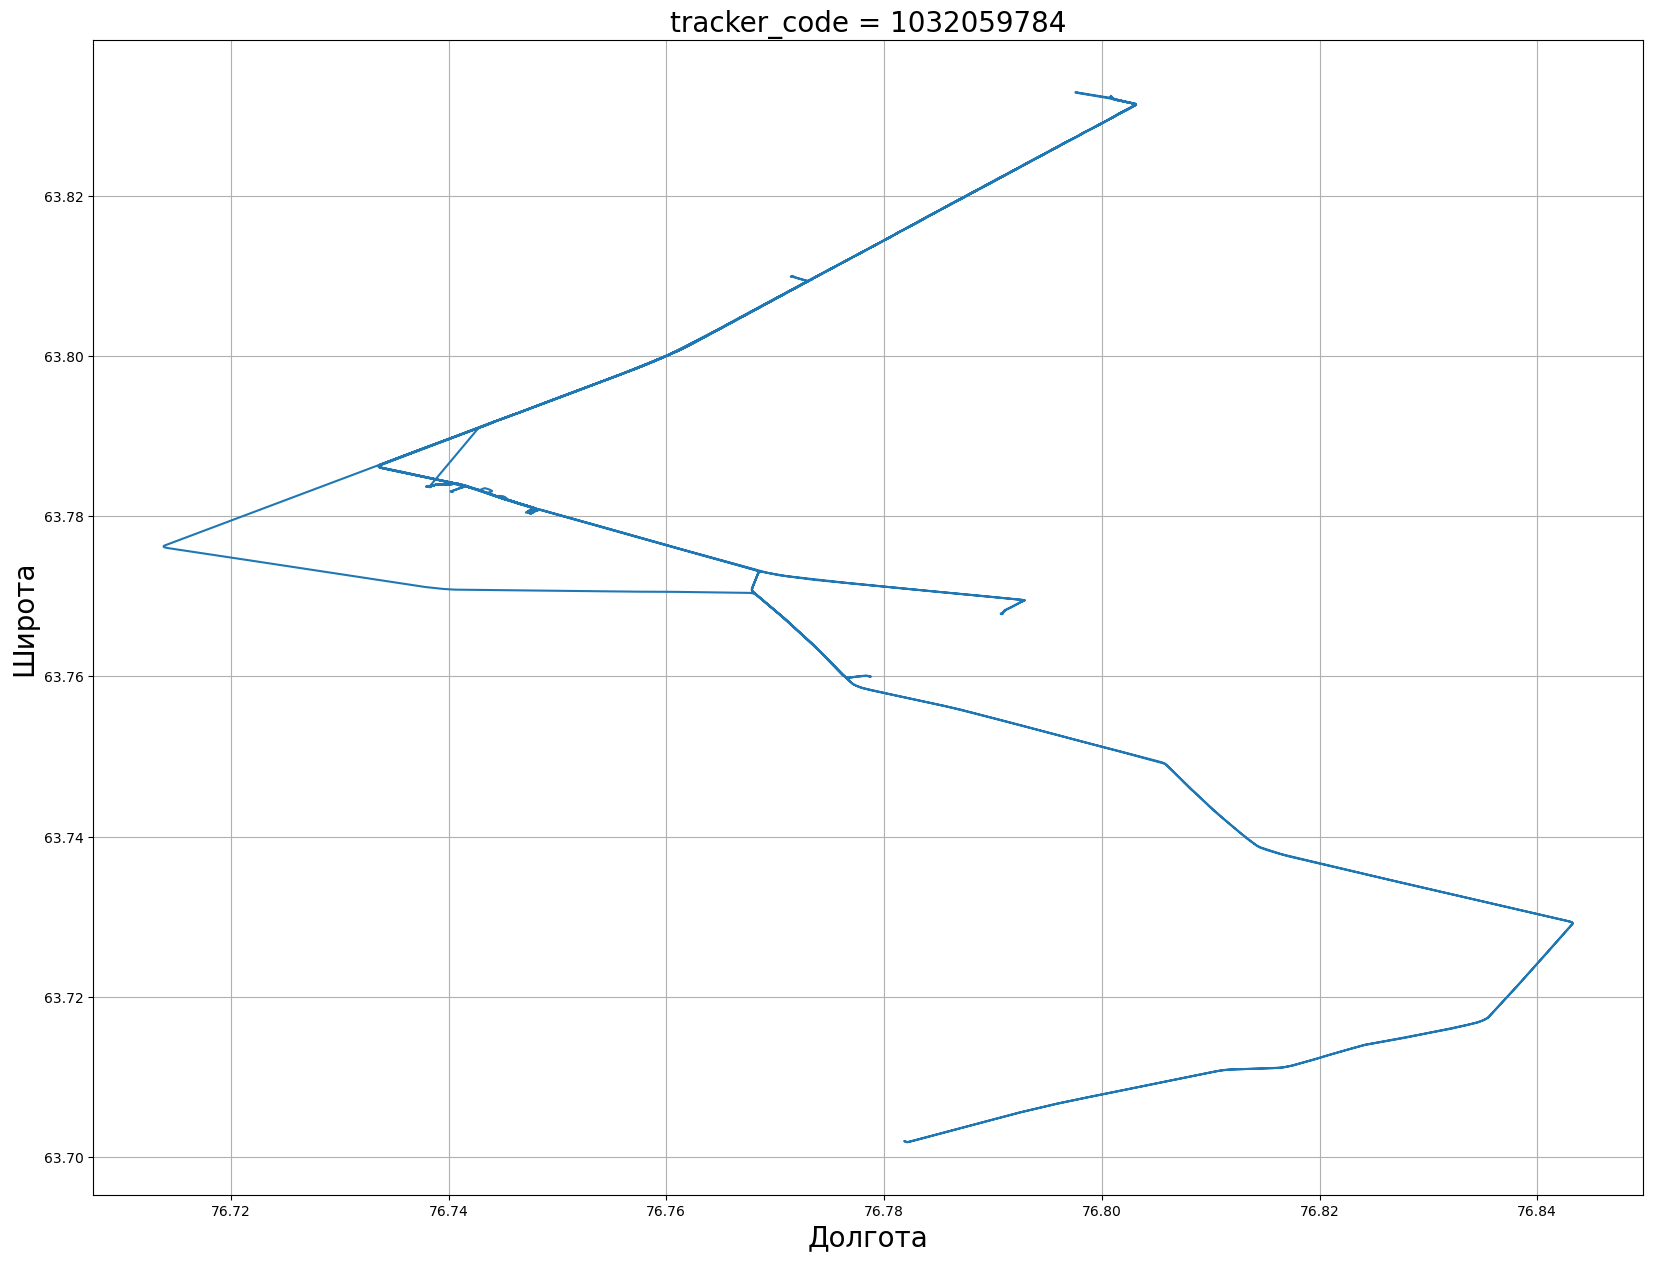

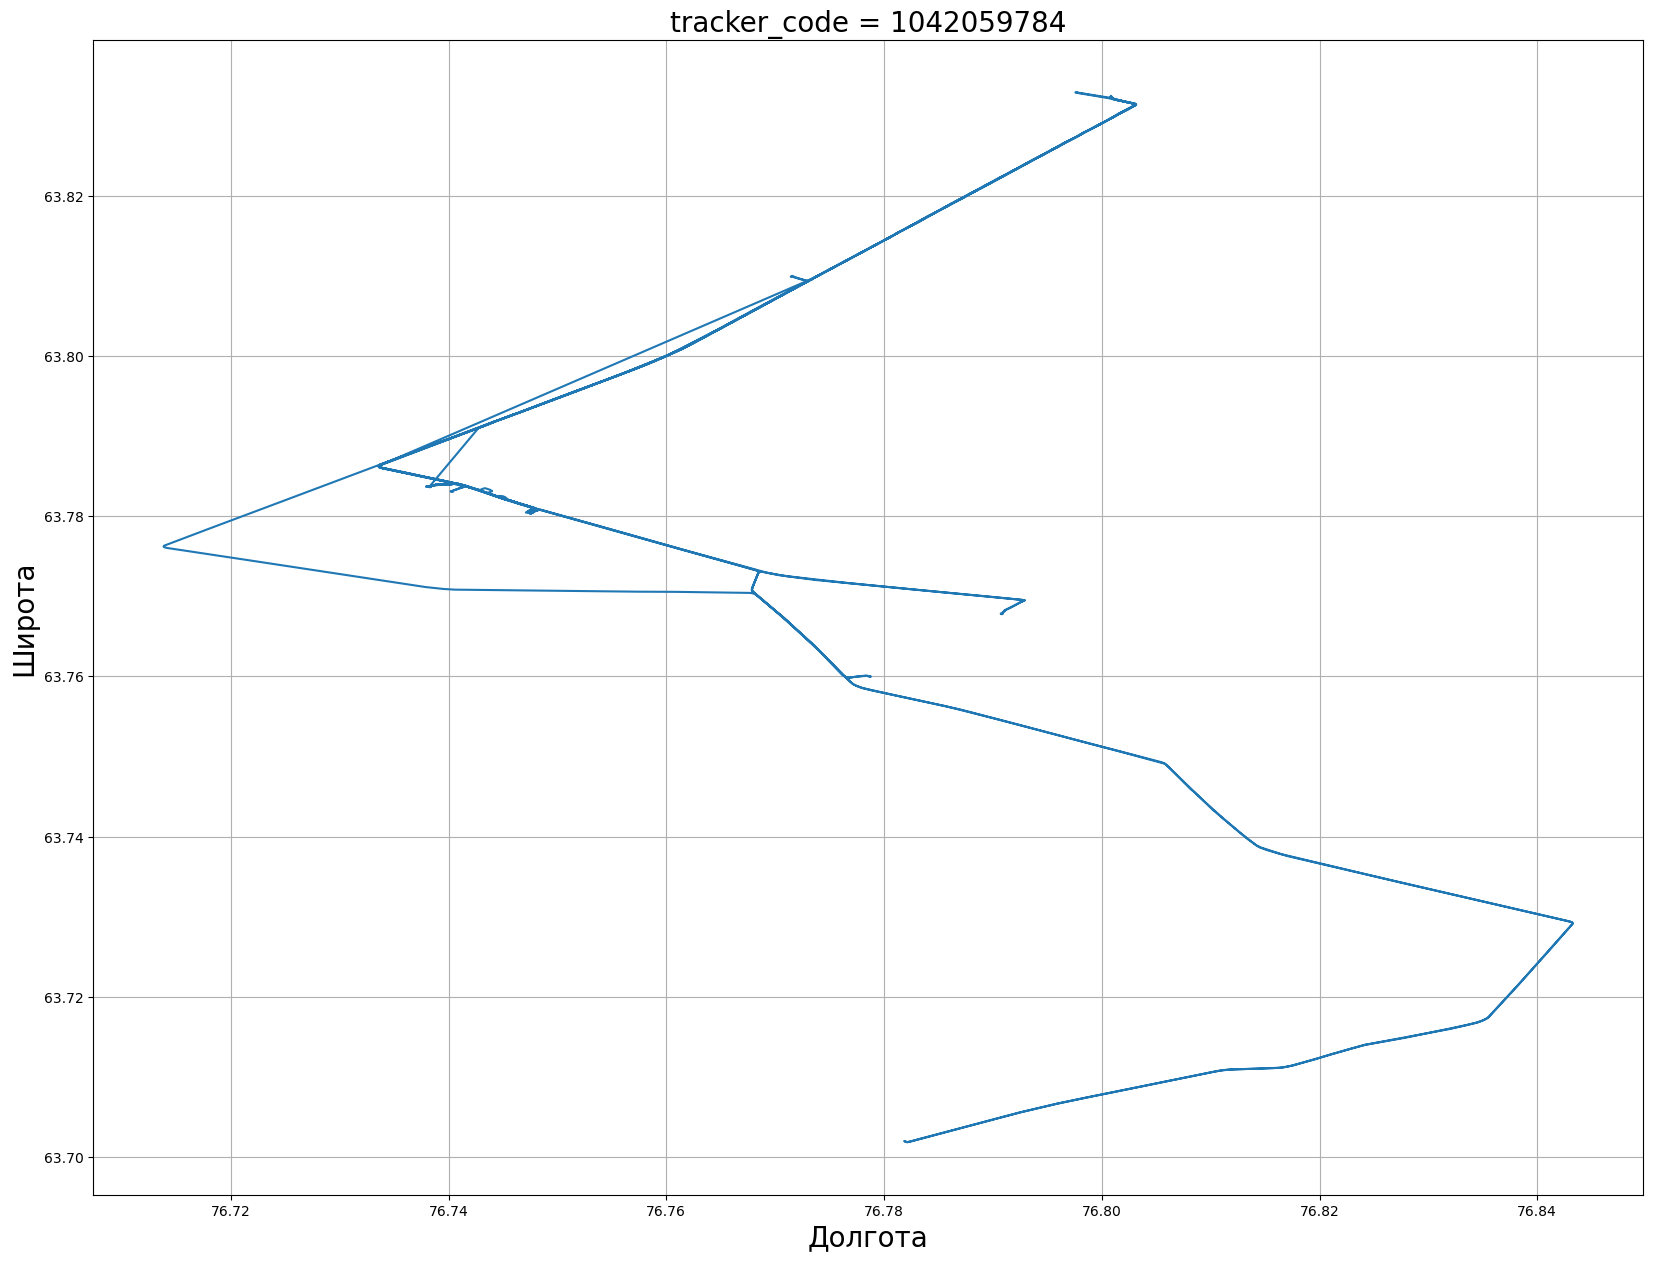

In [29]:
for tracker_code in list_dup1: 
    track(tracker_code)

На вышеприведённом примере видно, что tracker_code у треков отличаются одной цифрой, а геометрии треков полностью одинаковы.

Посмотрим на второй пример.

In [30]:
ser.index[1]

(Timestamp('2023-05-11 08:29:39'), 63.791754982385726, 76.74414797610234)

In [31]:
ser_dup2 = df[(df['latitude'] == 63.78092799423749) & (df['longitude'] == 76.74785499850938)]['tracker_code']
list_dup2 = list(ser_dup2)
list_dup2.sort()
list_dup2

[]

In [32]:
for tracker_code in list_dup2: 
    track(tracker_code)

По второму примеру видно, что это те же самые 5 треков из первого примера.

In [33]:
len(gh

SyntaxError: incomplete input (2565058926.py, line 1)

# Группировка датасета по идентификатору трека

In [ ]:
df.head()

### Расчёт среднего количества спутников nsat для каждого трека

Создаётся датафрейм с группировкой по столбцу **tracker_code** и агрегированием столбца **nsat** по среднему значению.

In [ ]:
tracks = pd.DataFrame(df.groupby(['tracker_code'])['nsat'].mean())
tracks.columns = ['nsat_mean']
tracks['nsat_mean'] = tracks['nsat_mean'].apply(lambda x: round(x, 3))

# Перевод индексов в отдельный столбец
tracks.reset_index(inplace = True)

tracks

Таким образом был получен новый датафрейм, к которому будут прибавляться другие колонки, агрегированные различными способами относительно каждого трека.

### Расчёт средней скорости speed для каждого трека

In [ ]:
sub_df = pd.DataFrame(df.groupby(['tracker_code'])['speed'].mean())
sub_df.columns = ['speed_mean']
sub_df.reset_index(drop = True, inplace = True)
tracks = pd.concat([tracks, sub_df], axis = 1)
tracks['speed_mean'] = tracks['speed_mean'].apply(lambda x: round(x, 3))
tracks

### Расчёт длин треков

In [ ]:
# Время работы кода 35 мин

tracker_codes = df['tracker_code'].unique()
tracker_codes.sort()

track_lens = []

for tracker_code in tracker_codes:
    
    coordinates = list(zip(df[df.tracker_code == tracker_code]['longitude'], 
                           df[df.tracker_code == tracker_code]['latitude']))
    
    length = 0
    for i in range(1, len(coordinates)):
        
        lon1, lat1 = coordinates[i-1]
        lon2, lat2 = coordinates[i]
        
        length += haversine(lon1, lat1, lon2, lat2)
    
    track_lens.append(round(length, 3))
    
tracks['track_length'] = pd.Series(track_lens)

# Округлим значения в столбце до 3-х знаков после запятой
tracks['track_length'] = tracks['track_length'].apply(lambda x: round(x, 3))
tracks

### Расчёт времени работы машины

In [ ]:
sub_df = pd.DataFrame(df.groupby(['tracker_code'])['navigation_time'].min())
sub_df.columns = ['navigation_time_min']
sub_df['navigation_time_max'] = df.groupby(['tracker_code'])['navigation_time'].max()
sub_df.reset_index(drop = True, inplace = True)
tracks = pd.concat([tracks, sub_df], axis = 1)
tracks['navigation_time'] = tracks['navigation_time_max'] - tracks['navigation_time_min']
#tracks.drop(['navigation_time_max', 'navigation_time_min'], axis = 1, inplace = True)
tracks

In [ ]:
tracks.to_csv('tracks.csv', index = False)

In [ ]:
#len(gh

# Загрузка  датасета tracks из файла

In [34]:
tracks = pd.read_csv('tracks.csv')

In [35]:
tracks.info()
tracks.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26424 entries, 0 to 26423
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   tracker_code         26424 non-null  int64  
 1   nsat_mean            24471 non-null  float64
 2   speed_mean           26424 non-null  float64
 3   track_length         26424 non-null  float64
 4   navigation_time_min  26424 non-null  object 
 5   navigation_time_max  26424 non-null  object 
 6   navigation_time      26424 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 1.4+ MB


,tracker_code,nsat_mean,speed_mean,track_length,navigation_time_min,navigation_time_max,navigation_time
0,0,14.911,41.265,3.752681e+07,2023-05-11 00:00:02,2023-05-11 23:59:55,0 days 23:59:53
1,4,18.493,32.364,3.484895e+04,2023-05-11 02:28:27,2023-05-11 22:07:58,0 days 19:39:31
2,9,18.171,32.720,1.288970e+02,2023-05-11 02:26:25,2023-05-11 12:29:45,0 days 10:03:20
3,59,15.465,26.767,7.955900e+01,2023-05-11 01:50:57,2023-05-11 22:57:40,0 days 21:06:43
4,204,18.902,27.952,5.147600e+01,2023-05-11 02:36:59,2023-05-11 12:38:40,0 days 10:01:41


In [36]:
tracks.isna().sum()

tracker_code              0
nsat_mean              1953
speed_mean                0
track_length              0
navigation_time_min       0
navigation_time_max       0
navigation_time           0
dtype: int64

# EDA датасета tracks

### track_length

<Axes: >

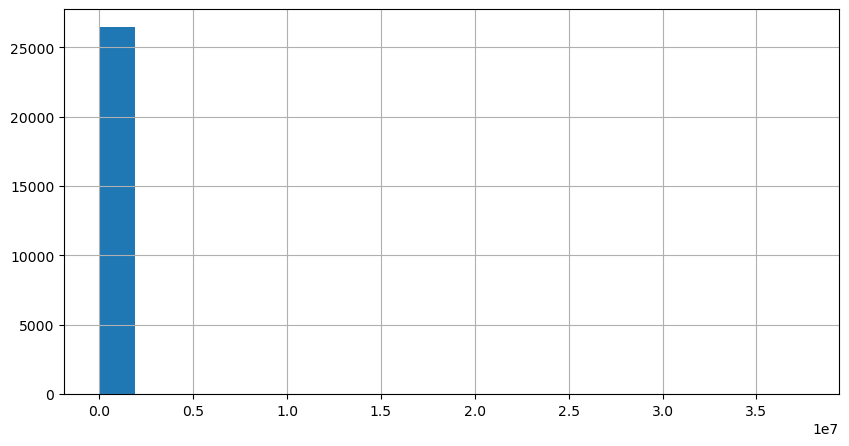

In [37]:
plt.figure(figsize = (10,5))
tracks.track_length.hist(bins=20)

Визуально у данного столбца видны выбросы. Проанализируем их.

In [38]:
#tracks[(tracks['track_length'] > 1300) & (tracks['track_length'] < 1400)]
tracks[tracks['track_length'] > 1400][:10]

,tracker_code,nsat_mean,speed_mean,track_length,navigation_time_min,navigation_time_max,navigation_time
0,0,14.911,41.265,3.752681e+07,2023-05-11 00:00:02,2023-05-11 23:59:55,0 days 23:59:53
1,4,18.493,32.364,3.484895e+04,2023-05-11 02:28:27,2023-05-11 22:07:58,0 days 19:39:31
37,1203,3.323,35.422,1.302126e+04,2023-05-11 03:07:42,2023-05-11 20:25:22,0 days 17:17:40
133,10014,18.314,34.784,1.186964e+04,2023-05-11 01:38:25,2023-05-11 16:19:26,0 days 14:41:01
183,19973,NaN,23.577,1.751439e+05,2023-05-11 00:00:00,2023-05-11 23:59:11,0 days 23:59:11
1011,159903,13.614,41.371,8.969756e+03,2023-05-11 01:59:08,2023-05-11 11:09:10,0 days 09:10:02
3293,418404,11.614,13.477,2.021931e+03,2023-05-11 00:10:49,2023-05-11 23:57:02,0 days 23:46:13
3976,439654,121.752,66.773,6.339228e+04,2023-05-11 00:00:17,2023-05-11 23:59:13,0 days 23:58:56
4017,440154,12.052,13.346,1.902250e+03,2023-05-11 03:50:22,2023-05-11 12:25:39,0 days 08:35:17
13163,33310225,NaN,16.766,4.350460e+04,2023-05-11 00:11:41,2023-05-11 23:03:27,0 days 22:51:46


In [39]:
tracker_code = 10014

length = tracks[tracks.tracker_code == tracker_code].track_length.iloc[0]
period = tracks[tracks.tracker_code == tracker_code].navigation_time.iloc[0]
speed = tracks[tracks.tracker_code == tracker_code].speed_mean.iloc[0]
print(f'Трек: {tracker_code}, Длина: {length}, Время работы: {period}, Средняя скорость: {speed}')
track_on_map(tracker_code)

Трек: 10014, Длина: 11869.643, Время работы: 0 days 14:41:01, Средняя скорость: 34.784


Map(center=[56.48933832219088, 66.58297333088306], controls=(ZoomControl(options=['position', 'zoom_in_text', …

В результате анализа можно сделать вывод о том, что выбросами следует считать длины треков больше 1400 км, т.к. это максимальное расстояние, которое может проехать машина за день. К тому же геометрия треков при таких показателях имеет неестественную форму.

Очистим датасет от строк с такими значениями столбца track_length.

In [40]:
outliers_ind = tracks[tracks['track_length'] > 1400].index
tracks.drop(outliers_ind, inplace = True)
tracks.reset_index(drop = True, inplace = True)

### navigation_time

Перевод времени к размерности [минуты].

In [41]:
tracks['navigation_time'] = tracks['navigation_time']/np.timedelta64(1, "m")
tracks['navigation_time'] = tracks['navigation_time'].apply(lambda x: round(x, 3))

### speed_mean

<Axes: >

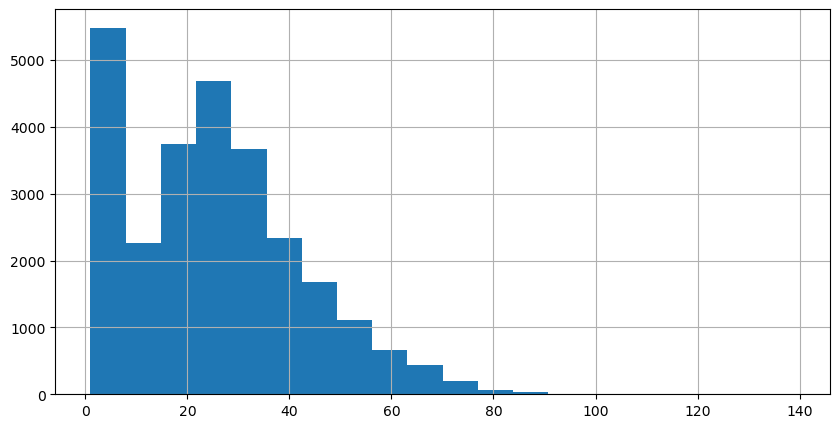

In [42]:
plt.figure(figsize = (10, 5))
tracks['speed_mean'].hist(bins = 20)

Удалим записи со значениями **speed_mean** менее 1 км/ч.

In [43]:
tracks.drop(tracks[tracks['speed_mean'] < 1].index, inplace = True)
tracks.reset_index(drop = True, inplace = True)

### nsat_mean

In [44]:
tracks['nsat_mean'].isna().sum()

1947

Столбец содержит 1851 пустую ячейку. Целесообразно заполнить их средним значением.

In [45]:
round(tracks['nsat_mean'].mean(), 3)

15.148

In [46]:
tracks['nsat_mean'] = tracks['nsat_mean'].fillna(15.294)

In [47]:
len(gh

SyntaxError: incomplete input (2565058926.py, line 1)

### Проверка датасета на дубликаты

In [48]:
sub_df_1 = pd.DataFrame(tracks[['track_length', 'speed_mean', 'navigation_time_min', 'navigation_time_max']].value_counts())
sub_df_1.reset_index(inplace = True)
sub_df_1.columns = ['track_length', 'speed_mean', 'navigation_time_min', 'navigation_time_max', 'count']
tracks_df1 = sub_df_1[(sub_df_1['count'] > 1) & (sub_df_1['track_length'] > 0.5)][['track_length', 'speed_mean', 
                                                         'navigation_time_min','navigation_time_max', 'count']]
tracks_df1

,track_length,speed_mean,navigation_time_min,navigation_time_max,count
0,66.597,38.898,2023-05-11 01:10:25,2023-05-11 02:39:21,3
2,34.539,26.702,2023-05-11 02:31:40,2023-05-11 23:02:51,2
6,9.091,14.292,2023-05-11 02:47:51,2023-05-11 06:13:04,2
7,93.839,30.760,2023-05-11 02:51:57,2023-05-11 11:21:48,2
8,8.461,9.099,2023-05-11 01:26:10,2023-05-11 04:44:13,2
9,28.695,31.229,2023-05-11 09:38:45,2023-05-11 11:25:16,2
10,0.927,4.096,2023-05-11 03:24:03,2023-05-11 11:35:09,2
12,1.703,7.512,2023-05-11 02:06:03,2023-05-11 03:22:36,2
13,196.474,50.234,2023-05-11 04:12:30,2023-05-11 11:07:03,2
14,7.911,13.525,2023-05-11 02:58:11,2023-05-11 15:59:11,2


In [49]:
dup_tracks1 = []
for i in range(len(tracks_df1)):
    dup_tracks1.append(list(tracks[(tracks['track_length'] == tracks_df1.track_length.iloc[i]) & \
                                   (tracks['speed_mean'] == tracks_df1.speed_mean.iloc[i]) & \
                                   (tracks['navigation_time_min'] == tracks_df1.navigation_time_min.iloc[i]) & \
                                   (tracks['navigation_time_max'] == tracks_df1.navigation_time_max.iloc[i])]['tracker_code']))
    
print(f'len(dup_tracks1) = {len(dup_tracks1)}')
dup_tracks1

len(dup_tracks1) = 49


[[229175, 1020229175, 1030229175],
 [265448, 3340052648],
 [102387170, 1022387170],
 [124786558, 1055697273],
 [40570122, 146052270],
 [33168475, 1913358939],
 [35909207, 1916099671],
 [1013062136, 1043062136],
 [920238, 1886956810],
 [801815906, 1021167586],
 [42919759, 1643495247],
 [1010056490, 1020056490],
 [159328523, 1045936779],
 [914430, 2360914430],
 [1011307521, 1041307521],
 [51080797, 1021080797],
 [1027457645, 1548644129],
 [1018354294, 1048354294],
 [51404159, 66684233],
 [4460543, 3036026591],
 [241196749, 1054024269],
 [102278623, 1020278623],
 [39714736, 45699895],
 [35692530, 86588586],
 [21545626, 52071349],
 [42201955, 2824917347],
 [33300333, 61971447],
 [102344123, 1025344123],
 [194003488, 1054016928],
 [2132777076, 2636895418],
 [21561896, 62006946],
 [41221248, 43875955],
 [1020214448, 1021375015],
 [21561380, 40515655],
 [1047593923, 1276711875],
 [1366045, 141366045],
 [2025634, 12025634],
 [34387116, 209999020],
 [34470987, 58223328],
 [32796062, 90917253],


In [50]:
sub_df_ = pd.DataFrame(tracks[['track_length', 'speed_mean']].value_counts())
sub_df_.reset_index(inplace = True)
sub_df_.columns = ['track_length', 'speed_mean', 'count']
tracks_df = sub_df_[(sub_df_['count'] > 1) & (sub_df_['track_length'] > 0.5)][['track_length', 'speed_mean', 'count']]
tracks_df

,track_length,speed_mean,count
56,66.597,38.898,3
61,0.709,7.568,2
62,1.177,10.934,2
63,144.048,46.981,2
65,88.441,27.680,2
66,25.271,19.301,2
69,7.654,27.538,2
73,1.804,10.512,2
75,16.628,18.831,2
76,60.042,16.689,2


In [51]:
dup_tracks = []
for i in range(len(tracks_df)):
    dup_tracks.append(list(tracks[(tracks['track_length'] == tracks_df.track_length.iloc[i]) & \
                                  (tracks['speed_mean'] == tracks_df.speed_mean.iloc[i])]['tracker_code']))
    
print(f'len(dup_tracks1) = {len(dup_tracks)}')
dup_tracks

len(dup_tracks1) = 50


[[229175, 1020229175, 1030229175],
 [51080797, 1021080797],
 [21561380, 40515655],
 [194003488, 1054016928],
 [4460543, 3036026591],
 [51404159, 66684233],
 [2025634, 12025634],
 [34470987, 58223328],
 [2391822622, 2393823248],
 [3293280, 31797837],
 [801815906, 1021167586],
 [9039154, 2281000137],
 [914430, 2360914430],
 [40570122, 146052270],
 [33300333, 61971447],
 [1366045, 141366045],
 [41221248, 43875955],
 [34387116, 209999020],
 [21561896, 62006946],
 [21545626, 52071349],
 [33168475, 1913358939],
 [1013062136, 1043062136],
 [102344123, 1025344123],
 [124786558, 1055697273],
 [1020214448, 1021375015],
 [102278623, 1020278623],
 [2058562, 336011922],
 [35909207, 1916099671],
 [918322, 2360918322],
 [1018354294, 1048354294],
 [1047593923, 1276711875],
 [265448, 3340052648],
 [2553660, 2825269052],
 [102387170, 1022387170],
 [39714736, 45699895],
 [1010056490, 1020056490],
 [2073236, 12073236],
 [241196749, 1054024269],
 [920238, 1886956810],
 [1011307521, 1041307521],
 [41732691,

Определяем треки, которые не совпадают по времени начала и конца работы.

In [52]:
count = 0
list_dif = []
for list_track in dup_tracks:
    if list_track in dup_tracks1:
        count += 1
    else:
        print(list_track)

[2058562, 336011922]


In [53]:
#len(gh

In [54]:
102059784, 1012059784, 1022059784, 1032059784, 1042059784

(102059784, 1012059784, 1022059784, 1032059784, 1042059784)

In [55]:
tracker_code = 102059784

length = tracks[tracks.tracker_code == tracker_code].track_length.iloc[0]
period = tracks[tracks.tracker_code == tracker_code].navigation_time.iloc[0]
speed = tracks[tracks.tracker_code == tracker_code].speed_mean.iloc[0]
print('\n')
print(f'Трек: {tracker_code}, Длина: {round(length, 3)} км, Время работы: {round(period/60, 1)} ч, \
Средняя скорость: {round(speed, 1)} км/ч')
track_on_map(tracker_code)



Трек: 102059784, Длина: 91.445 км, Время работы: 13.2 ч, Средняя скорость: 21.0 км/ч


Map(center=[63.78371499799744, 76.73798597807483], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [56]:
tracker_code = 1012059784

length = tracks[tracks.tracker_code == tracker_code].track_length.iloc[0]
period = tracks[tracks.tracker_code == tracker_code].navigation_time.iloc[0]
speed = tracks[tracks.tracker_code == tracker_code].speed_mean.iloc[0]
print('\n')
print(f'Трек: {tracker_code}, Длина: {round(length, 3)} км, Время работы: {round(period/60, 1)} ч, \
Средняя скорость: {round(speed, 1)} км/ч')
track_on_map(tracker_code)



Трек: 1012059784, Длина: 91.438 км, Время работы: 13.2 ч, Средняя скорость: 20.8 км/ч


Map(center=[63.78371499799744, 76.73798597807483], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [57]:
tracker_code = 1022059784

length = tracks[tracks.tracker_code == tracker_code].track_length.iloc[0]
period = tracks[tracks.tracker_code == tracker_code].navigation_time.iloc[0]
speed = tracks[tracks.tracker_code == tracker_code].speed_mean.iloc[0]
print('\n')
print(f'Трек: {tracker_code}, Длина: {round(length, 3)} км, Время работы: {round(period/60, 1)} ч, \
Средняя скорость: {round(speed, 1)} км/ч')
track_on_map(tracker_code)



Трек: 1022059784, Длина: 89.227 км, Время работы: 13.2 ч, Средняя скорость: 21.0 км/ч


Map(center=[63.78371499799744, 76.73798597807483], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [58]:
tracker_code = 1032059784

length = tracks[tracks.tracker_code == tracker_code].track_length.iloc[0]
period = tracks[tracks.tracker_code == tracker_code].navigation_time.iloc[0]
speed = tracks[tracks.tracker_code == tracker_code].speed_mean.iloc[0]
print('\n')
print(f'Трек: {tracker_code}, Длина: {round(length, 3)} км, Время работы: {round(period/60, 1)} ч, \
Средняя скорость: {round(speed, 1)} км/ч')
track_on_map(tracker_code)



Трек: 1032059784, Длина: 89.227 км, Время работы: 13.2 ч, Средняя скорость: 21.0 км/ч


Map(center=[63.78371499799744, 76.73798597807483], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [59]:
tracker_code = 1042059784

length = tracks[tracks.tracker_code == tracker_code].track_length.iloc[0]
period = tracks[tracks.tracker_code == tracker_code].navigation_time.iloc[0]
speed = tracks[tracks.tracker_code == tracker_code].speed_mean.iloc[0]
print('\n')
print(f'Трек: {tracker_code}, Длина: {round(length, 3)} км, Время работы: {round(period/60, 1)} ч, \
Средняя скорость: {round(speed, 1)} км/ч')
track_on_map(tracker_code)



Трек: 1042059784, Длина: 91.538 км, Время работы: 13.2 ч, Средняя скорость: 20.9 км/ч


Map(center=[63.78371499799744, 76.73798597807483], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [60]:
tracker_code = 42919759

length = tracks[tracks.tracker_code == tracker_code].track_length.iloc[0]
period = tracks[tracks.tracker_code == tracker_code].navigation_time.iloc[0]
speed = tracks[tracks.tracker_code == tracker_code].speed_mean.iloc[0]
print('\n')
print(f'Трек: {tracker_code}, Длина: {round(length, 3)} км, Время работы: {round(period/60, 1)} ч, \
Средняя скорость: {round(speed, 1)} км/ч')
track_on_map(tracker_code)



Трек: 42919759, Длина: 1.029 км, Время работы: 8.9 ч, Средняя скорость: 5.0 км/ч


Map(center=[59.24128998984613, 74.33713997582373], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [61]:
tracker_code = 1643495247

length = tracks[tracks.tracker_code == tracker_code].track_length.iloc[0]
period = tracks[tracks.tracker_code == tracker_code].navigation_time.iloc[0]
speed = tracks[tracks.tracker_code == tracker_code].speed_mean.iloc[0]
print('\n')
print(f'Трек: {tracker_code}, Длина: {round(length, 3)} км, Время работы: {round(period/60, 1)} ч, \
Средняя скорость: {round(speed, 1)} км/ч')
track_on_map(tracker_code)



Трек: 1643495247, Длина: 1.029 км, Время работы: 8.9 ч, Средняя скорость: 5.0 км/ч


Map(center=[59.24128998984613, 74.33713997582373], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [62]:
tracks[tracks['tracker_code'] == 42919759][['tracker_code', 'navigation_time_min', 'navigation_time_max']]

,tracker_code,navigation_time_min,navigation_time_max
14092,42919759,2023-05-11 03:43:57,2023-05-11 12:36:42


In [63]:
tracks[tracks['tracker_code'] == 1643495247][['tracker_code', 'navigation_time_min', 'navigation_time_max']]

,tracker_code,navigation_time_min,navigation_time_max
22763,1643495247,2023-05-11 03:43:57,2023-05-11 12:36:42


In [64]:
df[df['tracker_code'] == 42919759]['speed'].max()

10

In [65]:
df[df['tracker_code'] == 42919759]['speed'].min()

1

In [66]:
print(df[df['tracker_code'] == 42919759]['latitude'].iloc[0])
print(df[df['tracker_code'] == 42919759]['longitude'].iloc[0])

59.24128998984613
74.33713997582373


### Построение корреляционной матрицы

<Axes: >

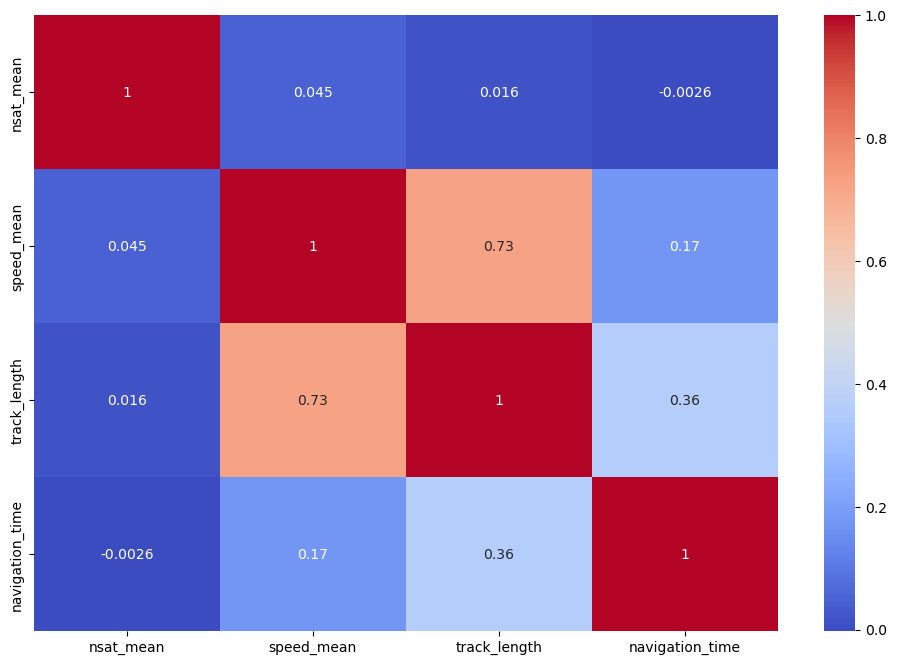

In [67]:
plt.figure(figsize = (12, 8))
correlation = tracks.drop(['tracker_code', 'navigation_time_max', 'navigation_time_min'], axis = 1).corr()
sns.heatmap(correlation, cmap = 'coolwarm', annot = True)

Большая корреляция наблюдается между признаком **track_length** с признаками **speed_mean** - 0.59 и **navigation_time** - 0.26. Это имеет логичное объяснение, т. к. признаки **speed_mean** и **navigation_time** имеют прямо пропорциональную зависимость с признаком **track_length**.

# Кластеризация

In [68]:
tracks.head()

,tracker_code,nsat_mean,speed_mean,track_length,navigation_time_min,navigation_time_max,navigation_time
0,9,18.171,32.720,128.897,2023-05-11 02:26:25,2023-05-11 12:29:45,603.333
1,59,15.465,26.767,79.559,2023-05-11 01:50:57,2023-05-11 22:57:40,1266.717
2,204,18.902,27.952,51.476,2023-05-11 02:36:59,2023-05-11 12:38:40,601.683
3,292,4.000,6.364,0.390,2023-05-11 09:39:52,2023-05-11 09:46:23,6.517
4,322,6.000,4.778,0.171,2023-05-11 13:26:09,2023-05-11 13:51:17,25.133


In [69]:
X = tracks.drop(['tracker_code', 'navigation_time_max', 'navigation_time_min'], axis = 1)

Нормализация данных.

In [70]:
X = StandardScaler().fit_transform(X)

Обучение.

In [71]:
dbscan = DBSCAN(eps = 0.5, min_samples = 5)
dbscan.fit(X)
y_pred = dbscan.labels_
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{-1: 148, 0: 26193, 1: 31, 2: 9, 3: 10, 4: 5, 5: 5}

In [72]:
tracks['cluster'] = y_pred

In [73]:
tracks[tracks['cluster'] == 1].head()

,tracker_code,nsat_mean,speed_mean,track_length,navigation_time_min,navigation_time_max,navigation_time,cluster
195,32678,255.0,16.163,6.637,2023-05-11 03:13:08,2023-05-11 14:56:49,703.683,1
234,52383,255.0,23.493,82.808,2023-05-11 02:16:33,2023-05-11 13:10:59,654.433,1
427,103183,255.0,22.303,73.976,2023-05-11 07:02:37,2023-05-11 14:16:18,433.683,1
452,107275,255.0,26.419,18.147,2023-05-11 02:26:19,2023-05-11 23:03:19,1237.000,1
764,133908,255.0,31.568,75.042,2023-05-11 01:40:31,2023-05-11 13:43:11,722.667,1


In [74]:
tracker_code = tracks[tracks['cluster'] == 1]['tracker_code'].iloc[0]

length = tracks[tracks.tracker_code == tracker_code].track_length.iloc[0]
period = tracks[tracks.tracker_code == tracker_code].navigation_time.iloc[0]
speed = tracks[tracks.tracker_code == tracker_code].speed_mean.iloc[0]
cluster = tracks[tracks.tracker_code == tracker_code]['cluster'].iloc[0]
print('\n')
print(f'Трек: {tracker_code}, Длина: {round(length, 3)} км, Время работы: {round(period/60, 1)} ч, \
Средняя скорость: {round(speed, 1)} км/ч, Кластер: {cluster}')
track_on_map(tracker_code)



Трек: 32678, Длина: 6.637 км, Время работы: 11.7 ч, Средняя скорость: 16.2 км/ч, Кластер: 1


Map(center=[60.94522334424435, 76.49679663043861], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [75]:
tracker_code = tracks[tracks['cluster'] == 1]['tracker_code'].iloc[1]

length = tracks[tracks.tracker_code == tracker_code].track_length.iloc[0]
period = tracks[tracks.tracker_code == tracker_code].navigation_time.iloc[0]
speed = tracks[tracks.tracker_code == tracker_code].speed_mean.iloc[0]
cluster = tracks[tracks.tracker_code == tracker_code]['cluster'].iloc[0]
print('\n')
print(f'Трек: {tracker_code}, Длина: {round(length, 3)} км, Время работы: {round(period/60, 1)} ч, \
Средняя скорость: {round(speed, 1)} км/ч, Кластер: {cluster}')
track_on_map(tracker_code)



Трек: 52383, Длина: 82.808 км, Время работы: 10.9 ч, Средняя скорость: 23.5 км/ч, Кластер: 1


Map(center=[63.194226497596645, 75.44160512635521], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [76]:
tracks[tracks['cluster'] == 2].head()

,tracker_code,nsat_mean,speed_mean,track_length,navigation_time_min,navigation_time_max,navigation_time,cluster
1209,189161,255.0,3.000,0.00,2023-05-11 04:46:03,2023-05-11 04:46:03,0.000,2
1800,298281,255.0,3.333,0.03,2023-05-11 04:11:02,2023-05-11 04:11:39,0.617,2
11721,9016544,255.0,3.000,0.00,2023-05-11 04:10:10,2023-05-11 04:10:10,0.000,2
12290,10017088,255.0,4.000,0.00,2023-05-11 04:34:21,2023-05-11 04:34:21,0.000,2
12530,11788400,255.0,2.000,0.00,2023-05-11 04:58:27,2023-05-11 04:58:27,0.000,2


In [78]:
tracker_code = tracks[tracks['cluster'] == 2]['tracker_code'].iloc[0]

length = tracks[tracks.tracker_code == tracker_code].track_length.iloc[0]
period = tracks[tracks.tracker_code == tracker_code].navigation_time.iloc[0]
speed = tracks[tracks.tracker_code == tracker_code].speed_mean.iloc[0]
cluster = tracks[tracks.tracker_code == tracker_code]['cluster'].iloc[0]
print('\n')
print(f'Трек: {tracker_code}, Длина: {round(length, 3)} км, Время работы: {round(period/60, 1)} ч, \
Средняя скорость: {round(speed, 1)} км/ч, Кластер: {cluster}')
track_on_map(tracker_code)



Трек: 189161, Длина: 0.0 км, Время работы: 0.0 ч, Средняя скорость: 3.0 км/ч, Кластер: 2


Map(center=[66.70607165822435, 66.22077163919359], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [79]:
tracker_code = tracks[tracks['cluster'] == 2]['tracker_code'].iloc[1]

length = tracks[tracks.tracker_code == tracker_code].track_length.iloc[0]
period = tracks[tracks.tracker_code == tracker_code].navigation_time.iloc[0]
speed = tracks[tracks.tracker_code == tracker_code].speed_mean.iloc[0]
cluster = tracks[tracks.tracker_code == tracker_code]['cluster'].iloc[0]
print('\n')
print(f'Трек: {tracker_code}, Длина: {round(length, 3)} км, Время работы: {round(period/60, 1)} ч, \
Средняя скорость: {round(speed, 1)} км/ч, Кластер: {cluster}')
track_on_map(tracker_code)



Трек: 298281, Длина: 0.03 км, Время работы: 0.0 ч, Средняя скорость: 3.3 км/ч, Кластер: 2


Map(center=[61.19397664703288, 69.98726499033795], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [80]:
tracks[tracks['cluster'] == -1].head()

,tracker_code,nsat_mean,speed_mean,track_length,navigation_time_min,navigation_time_max,navigation_time,cluster
107,4061,126.104,60.903,751.439,2023-05-11 03:49:24,2023-05-11 22:19:07,1109.717,-1
112,6198,17.516,93.325,1112.850,2023-05-11 02:46:11,2023-05-11 18:42:30,956.317,-1
181,22005,255.000,43.460,326.866,2023-05-11 04:00:09,2023-05-11 18:05:29,845.333,-1
187,27604,255.000,57.080,278.859,2023-05-11 00:48:14,2023-05-11 08:12:22,444.133,-1
223,51430,15.294,83.914,159.760,2023-05-11 11:23:32,2023-05-11 13:42:40,139.133,-1


In [81]:
tracker_code = tracks[tracks['cluster'] == -1]['tracker_code'].iloc[0]

length = tracks[tracks.tracker_code == tracker_code].track_length.iloc[0]
period = tracks[tracks.tracker_code == tracker_code].navigation_time.iloc[0]
speed = tracks[tracks.tracker_code == tracker_code].speed_mean.iloc[0]
cluster = tracks[tracks.tracker_code == tracker_code]['cluster'].iloc[0]
print('\n')
print(f'Трек: {tracker_code}, Длина: {round(length, 3)} км, Время работы: {round(period/60, 1)} ч, \
Средняя скорость: {round(speed, 1)} км/ч, Кластер: {cluster}')
track_on_map(tracker_code)



Трек: 4061, Длина: 751.439 км, Время работы: 18.5 ч, Средняя скорость: 60.9 км/ч, Кластер: -1


Map(center=[56.411986997446974, 37.52318798506707], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [82]:
tracker_code = tracks[tracks['cluster'] == -1]['tracker_code'].iloc[1]

length = tracks[tracks.tracker_code == tracker_code].track_length.iloc[0]
period = tracks[tracks.tracker_code == tracker_code].navigation_time.iloc[0]
speed = tracks[tracks.tracker_code == tracker_code].speed_mean.iloc[0]
cluster = tracks[tracks.tracker_code == tracker_code]['cluster'].iloc[0]
print('\n')
print(f'Трек: {tracker_code}, Длина: {round(length, 3)} км, Время работы: {round(period/60, 1)} ч, \
Средняя скорость: {round(speed, 1)} км/ч, Кластер: {cluster}')
track_on_map(tracker_code)



Трек: 6198, Длина: 1112.85 км, Время работы: 15.9 ч, Средняя скорость: 93.3 км/ч, Кластер: -1


Map(center=[56.85706831907319, 60.5342682917915], controls=(ZoomControl(options=['position', 'zoom_in_text', '…

Построим корреляцию между признаками датасета и метками кластера.

<Axes: >

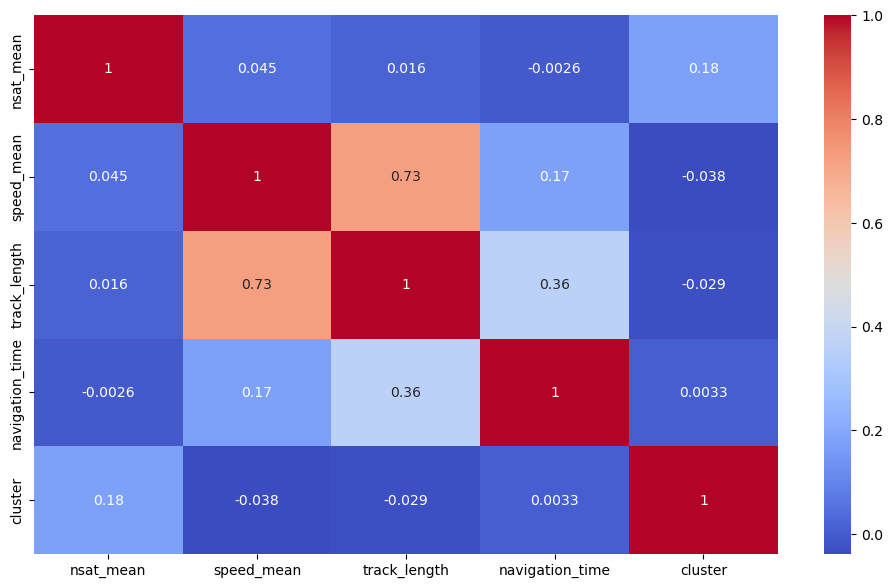

In [83]:
plt.figure(figsize = (12,7))
correlation = tracks.drop(['tracker_code', 'navigation_time_max', 'navigation_time_min'], axis = 1).corr()
sns.heatmap(correlation, cmap = 'coolwarm', annot = True)

Корреляция между признаками датасета и метками кластеров очень низкая, что говорит о крайне слабом влиянии признаков на образование кластеров. Помимо этого видно, что в данных фактически отсутствуют кластерная структура. На основании изложенного можно сделать вывод, что гипотеза поиска одинаковых треков с помощью кластеризации несостоятельна.